In [63]:
import os

import torch
import torch.nn as nn;
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torchvision.datasets import Food101
from torchvision.transforms import transforms

from modelpipe import DataPipeLine

**Base Model Prototyping**

Loading Data

In [3]:
os.chdir("..")
root_path = os.getcwd()
ds_path = os.path.join(root_path, "datasets")
ds_path

'c:\\Users\\amany\\OneDrive\\Desktop\\projects\\genAi\\VitModel\\Main\\datasets'

In [40]:
train_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
valid_transform = transforms.Compose([transforms.ToTensor()])

In [41]:
trainset = Food101(root=ds_path, download=True, split='train', transform=train_transform)
testset  = Food101(root=ds_path, download=True, split='test', transform=valid_transform)

In [44]:
train_loader = DataLoader(trainset, batch_size=32, shuffle = True)

test_loader = DataLoader(testset, batch_size=32, shuffle = True)

In [45]:
sample_batch = next(iter(train_loader))

In [51]:
sample_batch[0].size(1)

3

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Base Model

In [8]:
pretrained_model = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1)

In [9]:
class PretrainedBaseModel(nn.Module):
    def __init__(self, pretrained_model:nn.Module, freeze_model=True):
        super(PretrainedBaseModel, self).__init__()
        self.pt_model = pretrained_model
        self.model = self.pt_model.features

        if freeze_model:
            self.freeze();

    def freeze(self):
        for params in self.model.parameters():
            params.requires_grad = False
        self.model.eval() #to prevent batchnorm running -stats(mean & std) update (?)

    def forward(self, x):
        return self.model(x)


In [10]:
base_model = PretrainedBaseModel(pretrained_model)

In [11]:
x, y = trainset[0]

In [12]:
x = x.view(1, *x.shape)
x.shape

torch.Size([1, 3, 512, 512])

In [13]:
op = base_model(x)
op.shape

torch.Size([1, 1280, 16, 16])

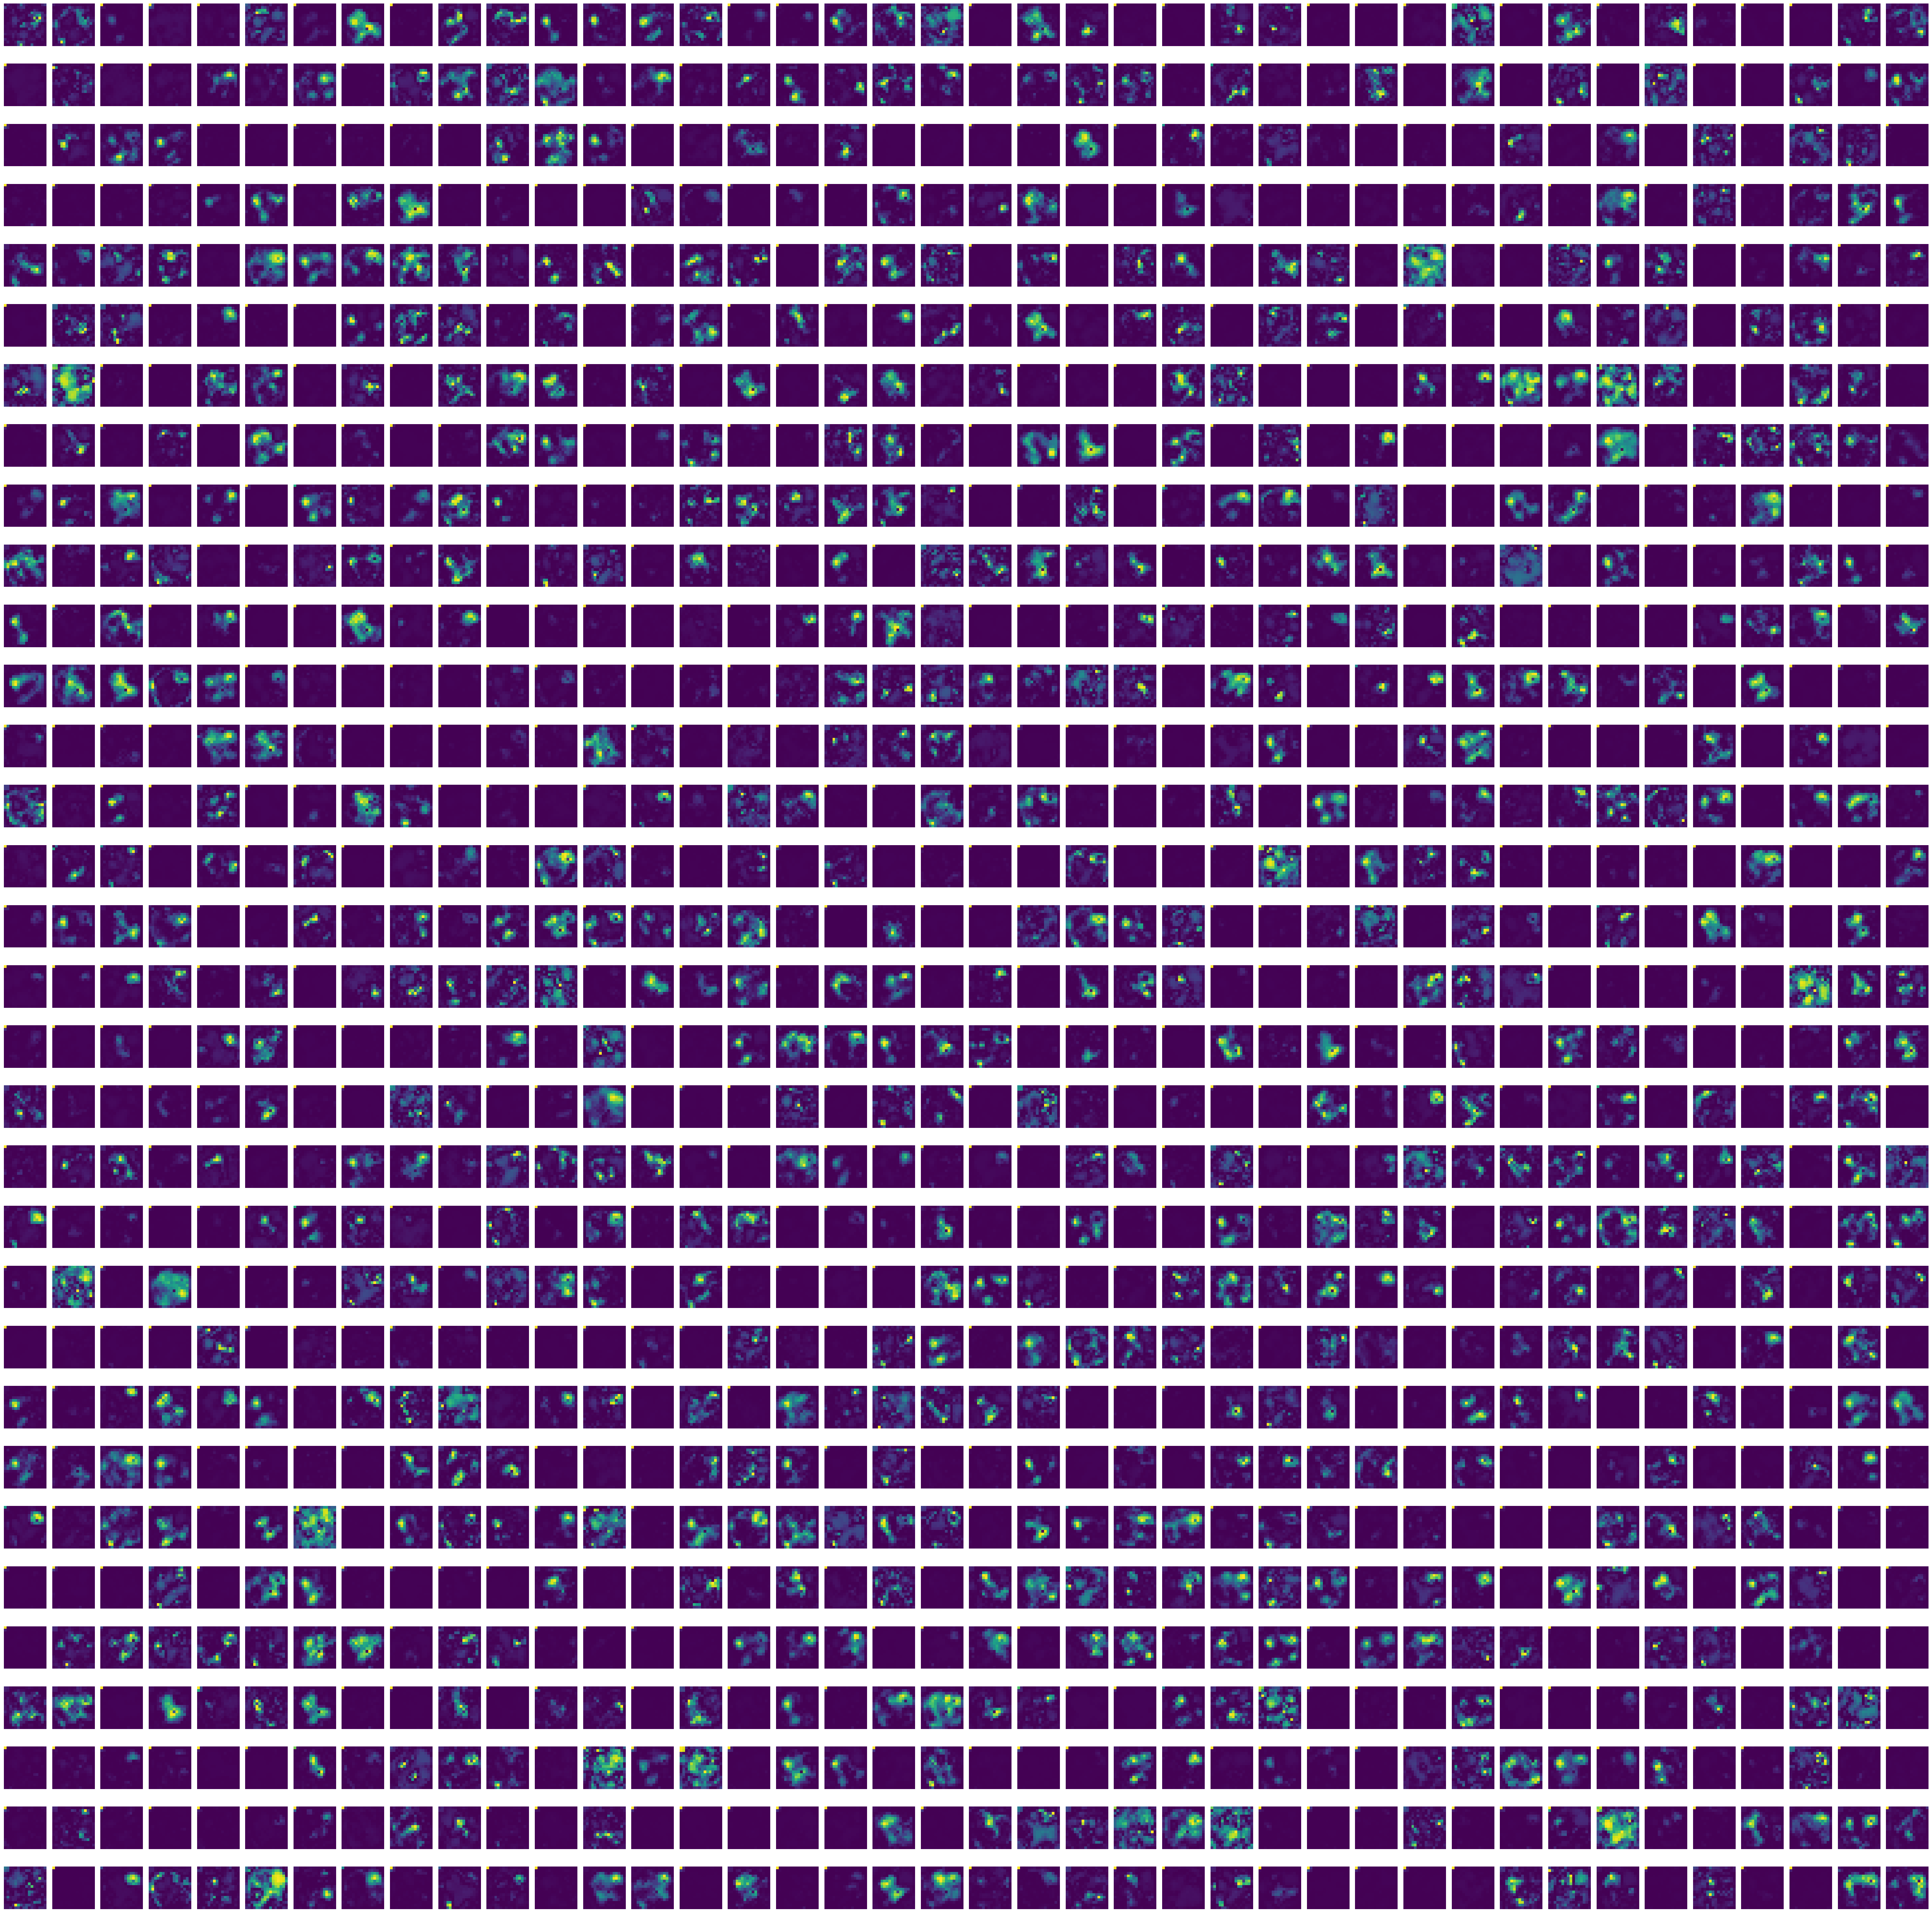

In [36]:

fig, axes = plt.subplots(32, 40, figsize=(50, 50))

for ax, img in zip(axes.flatten(), op[0]):
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.axis("off")
plt.show()

**PATCHIFICATION**

In [37]:
##CODE

**Positional Encodings**

In [14]:
# div_term = 1/(10000)^(2*i/dmodel) where i is the index in embeddings and dmodel is the embeding dimension
#to make calculation easy we here, find div_term for every varlue of 2*i where 2*i is even 
#thereby getting a tensor of div term for every index of embeddings
dmodel = 784
tokens = 100
pe = torch.zeros(tokens, dmodel)
emb_idx = torch.arange(0, dmodel, 2)
pos = torch.arange(100).unsqueeze(1)#token positions.

div_term = torch.exp(-(emb_idx/dmodel)*torch.log(torch.tensor(10000)))
pe[:, 0:dmodel:2] = torch.sin(pos * div_term)
pe[:, 1:dmodel:2] = torch.cos(pos * div_term)

In [59]:
pe[:50].unsqueeze(0).shape

torch.Size([1, 50, 784])

In [15]:
pe.shape

torch.Size([100, 784])

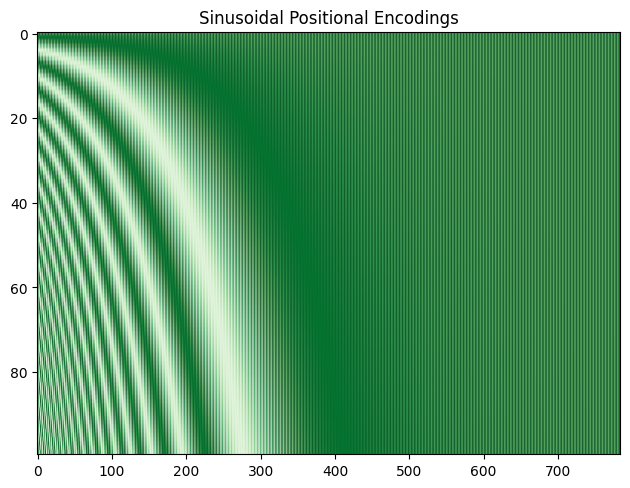

In [16]:
plt.imshow(pe, aspect='auto', cmap="Greens")
plt.tight_layout()
plt.title("Sinusoidal Positional Encodings")
plt.show()

In [136]:
import math

class PositionalEncodings(nn.Module):
    def __init__(self, seq_len, emb_dim):
        super(PositionalEncodings, self).__init__()
        self.dmodel = emb_dim

        pe = torch.zeros(seq_len, self.dmodel)
        emb_idx = torch.arange(0, self.dmodel//2, dtype=torch.float32)
        div_terms = torch.exp(-(2*emb_idx/self.dmodel) * math.log(10000))
        pos = torch.arange(seq_len).unsqueeze(1)

        pe[:, 0:self.dmodel:2] = torch.sin(pos * div_terms)
        pe[:, 1:self.dmodel:2] = torch.cos(pos * div_terms)

        self.register_buffer("pe",pe)

    def encoding_img(self):
        plt.imshow(self.pe.T, cmap='BuGn', aspect='auto')
        plt.tight_layout()
        plt.title("Sinusoidal Positional Encodings")
        plt.xlabel("Position")
        plt.ylabel("Encoding Index")
        plt.show()

    def forward(self, x):
        return x + self.pe[:x.size(1)].unsqueeze(0)

In [137]:
pE = PositionalEncodings(5000, 512)

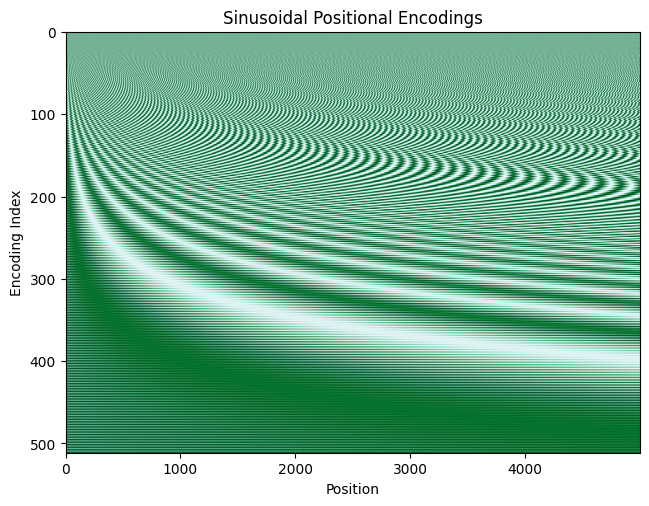

In [138]:
pE.encoding_img()